In [1]:
%load_ext autoreload
%autoreload 2

# Stations Visualized on the Map

In [40]:
from folium import Map, Popup
from folium.map import Marker
from folium.plugins import HeatMap
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist
plt.style.use('ggplot')

## Data

### Particle Concentrations

In [26]:
concentrations = pd.read_csv('data/beijing_17_18_aq.csv')
concentrations['datetime'] = pd.to_datetime(concentrations['utc_time'])
concentrations = concentrations.rename(columns={'stationId': 'station'}).drop('utc_time', axis=1)
#concentrations['station_type'] = concentrations['station'].apply(lambda s: s[s.find('_')+1:])
#concentrations['station'] = concentrations['station'].apply(lambda s: s[:s.find('_')])
concentrations.set_index(['station', 'datetime'], inplace=True)
dupes = concentrations[concentrations.index.duplicated()]
print('Index duplicates: {}'.format(dupes.shape[0]))
concentrations.drop(dupes.index, inplace=True)
concentrations.sample(3)

Index duplicates: 6475


,,PM2.5,PM10,NO2,CO,O3,SO2
station,datetime,,,,,,
wanliu_aq,2017-10-30 19:00:00,28.0,57.0,68.0,0.6,2.0,3.0
liulihe_aq,2017-02-15 14:00:00,NaN,401.0,150.0,3.6,2.0,39.0
aotizhongxin_aq,2017-04-14 12:00:00,49.0,120.0,37.0,0.2,78.0,2.0


### Weather

In [27]:
weather = pd.read_csv('data/beijing_17_18_meo.csv')
weather['datetime'] = pd.to_datetime(weather['utc_time'])
weather = weather.rename(columns={'station_id': 'station'}).drop('utc_time', axis=1)
weather['station_type'] = weather['station'].apply(lambda s: s[s.find('_')+1:])
weather['station'] = weather['station'].apply(lambda s: s[:s.find('_')])
weather.set_index(['station', 'datetime'], inplace=True)
weather.sample(3)

,,longitude,latitude,temperature,pressure,humidity,wind_direction,wind_speed,weather,station_type
station,datetime,,,,,,,,,
xiayunling,2017-02-08 09:00:00,115.740556,39.728611,-1.5,979.3,18,356.0,2.5,Sunny/clear,meo
shangdianzi,2017-05-14 10:00:00,117.111667,40.658889,24.6,977.8,15,358.0,2.7,Sunny/clear,meo
mentougou,2017-02-23 13:00:00,116.156389,39.887778,2.6,1016.1,40,193.0,2.0,Sunny/clear,meo


### Stations

In [28]:
stations = pd.read_csv('data/Beijing_AirQuality_Stations_en.csv')
stations = stations.rename(columns={'Station ID': 'station', 'Types': 'location_type'}).astype({'latitude' :float,
                                                                                               'longitude':float})
# stations['latitude'] = stations['latitude'].apply(lambda l: float(l.replace(',', '.')))
# stations['longitude'] = stations['longitude'].apply(lambda l: float(l.replace(',', '.')))
# stations['station_type'] = stations['station'].apply(lambda s: s[s.find('_')+1:])
# stations['station'] = stations['station'].apply(lambda s: s[:s.find('_')])
stations.set_index('station', inplace=True)
print(stations.shape)
stations.head()

(35, 3)


,longitude,latitude,location_type
station,,,
dongsi_aq,116.417,39.929,Urban
tiantan_aq,116.407,39.886,Urban
guanyuan_aq,116.339,39.929,Urban
wanshouxigong_aq,116.352,39.878,Urban
aotizhongxin_aq,116.397,39.982,Urban


## Maps 

In [29]:
from src.maps import map_points, distance_on_sphere_numpy, plot_dist_stations

### Airquality Stations

In [30]:
map_points(stations.reset_index(), plot_points=True, zoom_start=9)

We can group the stations by their location type and plot them all together.

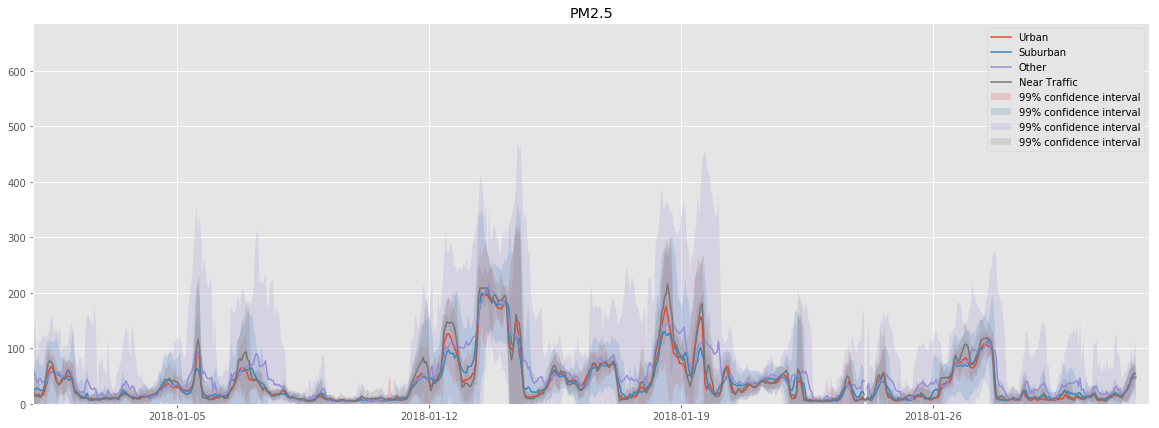

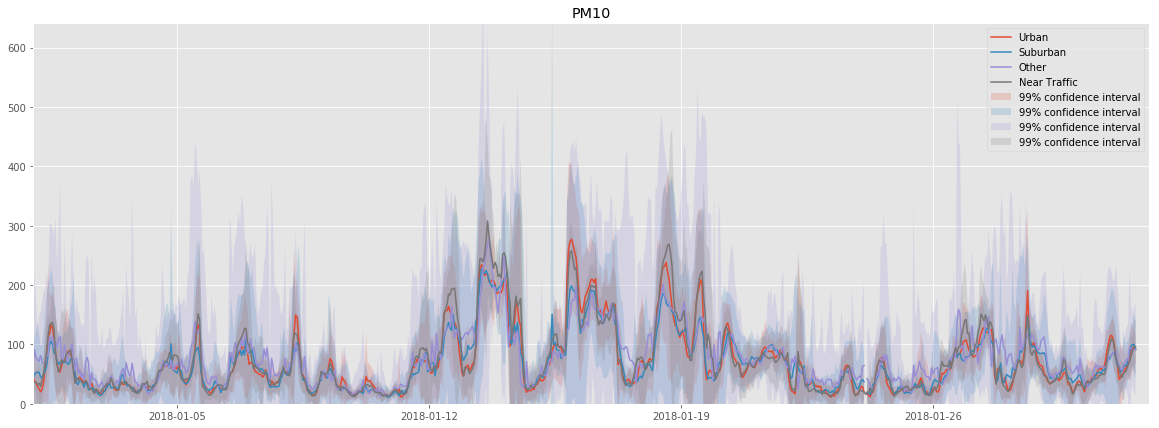

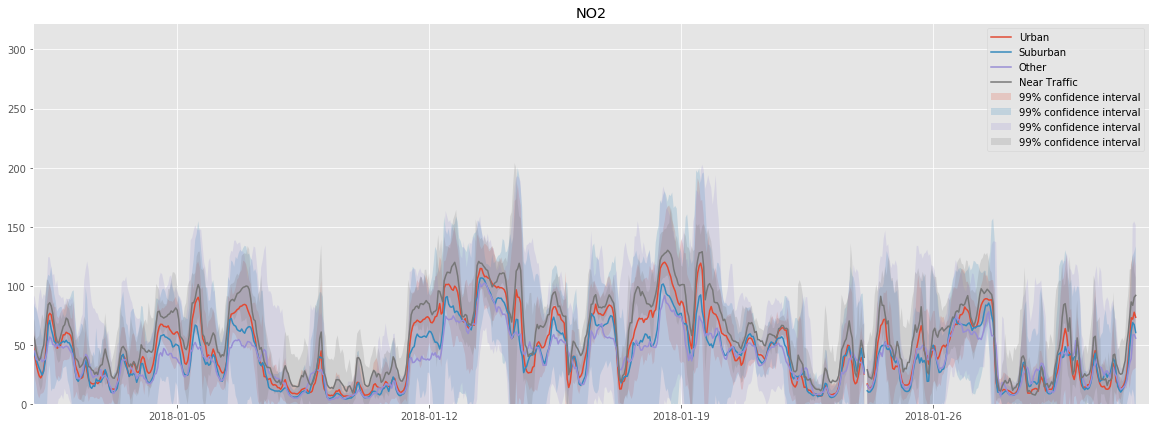

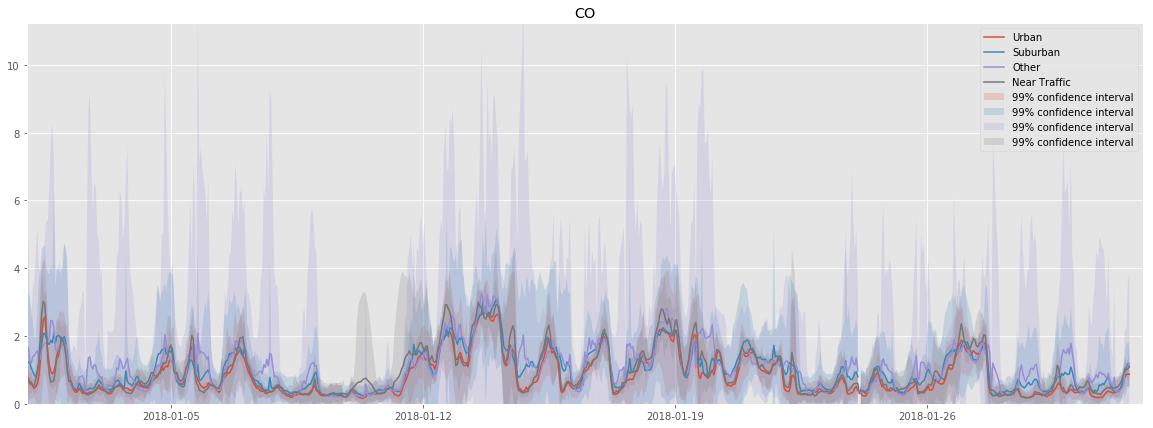

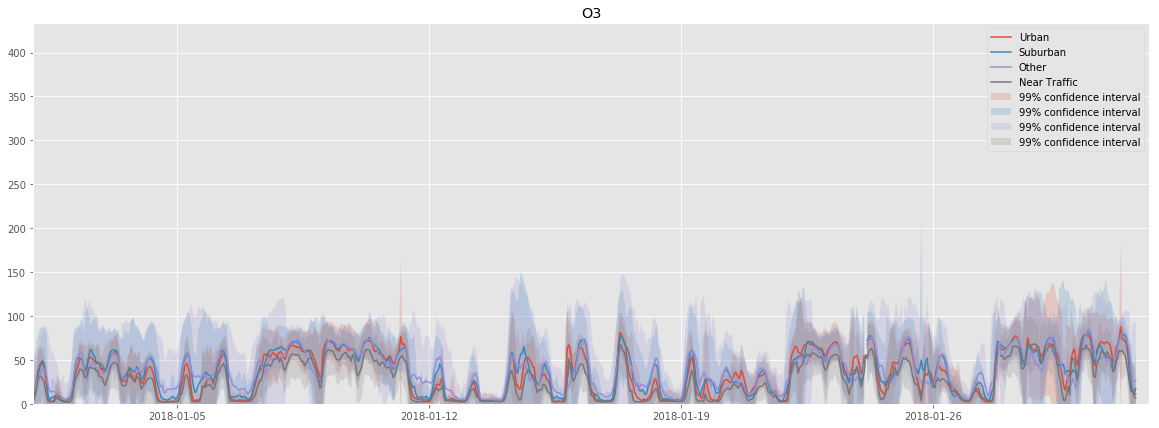

In [41]:
from numpy import percentile


for particle in concentrations.columns.tolist()[:-1]:
    plt.figure(figsize=(20, 7))
    for location_type in stations.location_type.unique():
        group_stations = stations[stations.location_type == location_type].index.tolist()
        group_summary = concentrations.loc[group_stations, particle].groupby('datetime').agg(['std', 'mean'])
        plt.plot(group_summary['mean'], label=location_type)
        plt.fill_between(group_summary['mean'].index,
                         group_summary['mean'] - 2.575 * group_summary['std'],
                         group_summary['mean'] + 2.575 * group_summary['std'],
                 alpha=.2, label='99% confidence interval')
        y_perc = 99.
        plt.ylim([0, percentile((group_summary['std'] + group_summary['mean'] * 1.96).fillna(0), y_perc)])
        plt.xlim(['2018-01', '2018-02'])
        plt.legend()
        plt.title(particle)
    plt.show()

### Weather Stations

In [42]:
map_points(weather.groupby('station').mean().reset_index(), plot_points=True, zoom_start=9)

## Time series of the different variables on airquality stations

### Daily

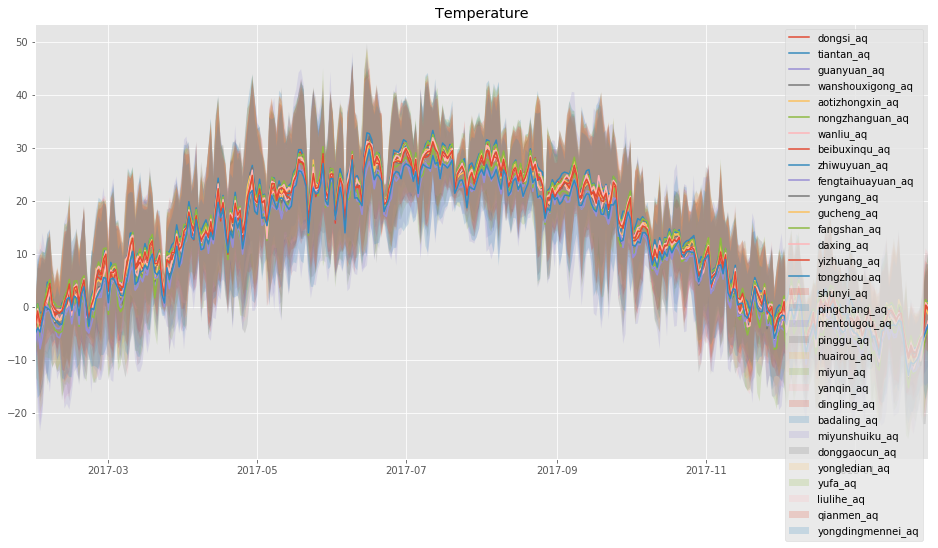

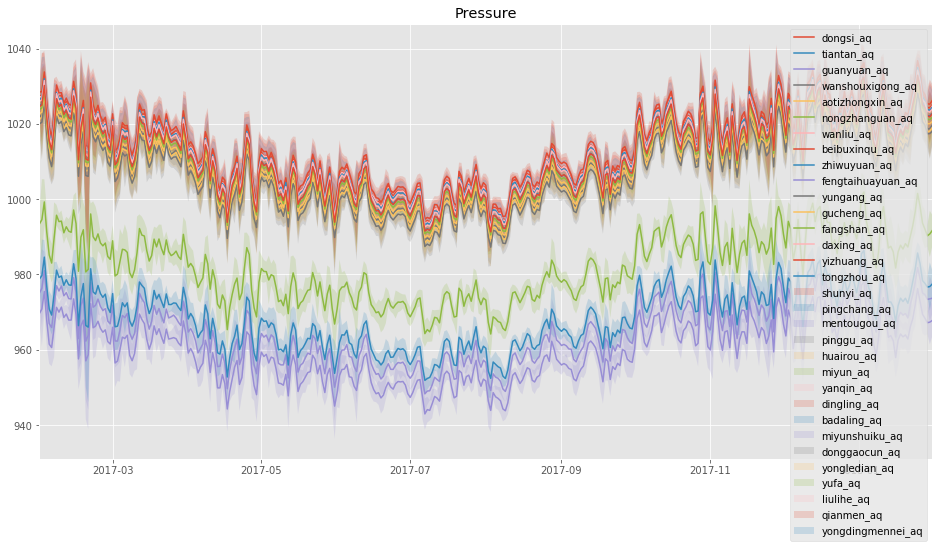

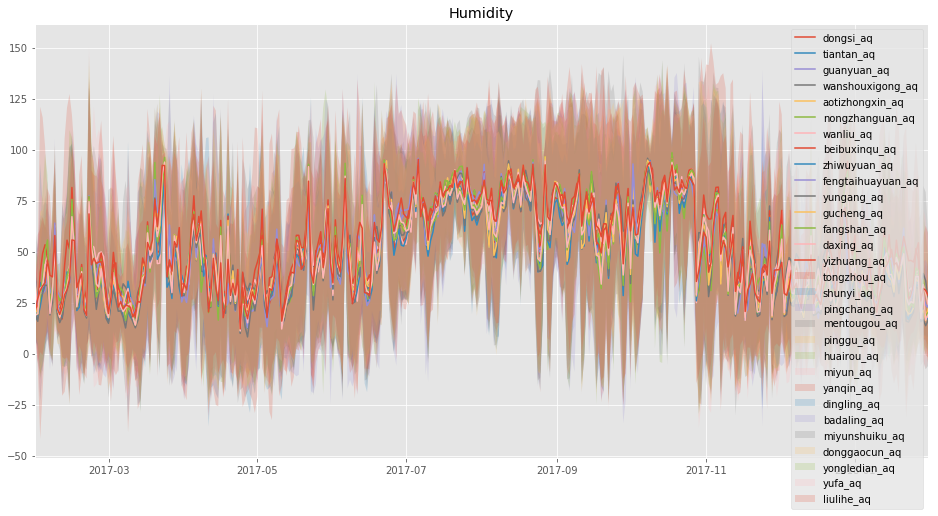

<Figure size 1152x576 with 0 Axes>

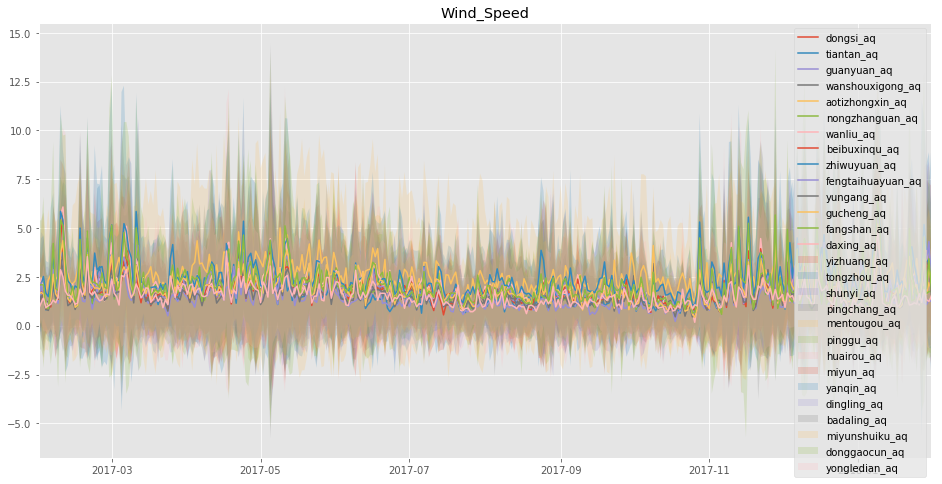

In [77]:
station_names = stations.index
w = weather.reset_index()
feature_names = w.columns.values[4:9]
for feature in feature_names:
    plt.figure(figsize=(16,8))
    for station in w.station.unique():
        resamples_mean = w[w['station'] == station].reset_index().set_index('datetime').resample('D').mean()[feature]
        resamples_std = w[w['station'] == station].reset_index().set_index('datetime').resample('D').std()[feature]
        if max(resamples_mean) > 1200:
            pass # There are some outliers. Might be due to bad collection of data
        else:    
            plt.plot(resamples_mean.index, resamples_mean, label = station)
            plt.fill_between(resamples_mean.index,
                         resamples_mean - 2.575 * resamples_std,
                         resamples_mean + 2.575 * resamples_std,
                 alpha=.2, label='99% confidence interval')
            y_perc = 99.
            plt.title(feature.title())
            plt.legend(station_names)
            plt.xlim([resamples_mean.index.min(),
                    resamples_mean.index.max()])

### Monthly

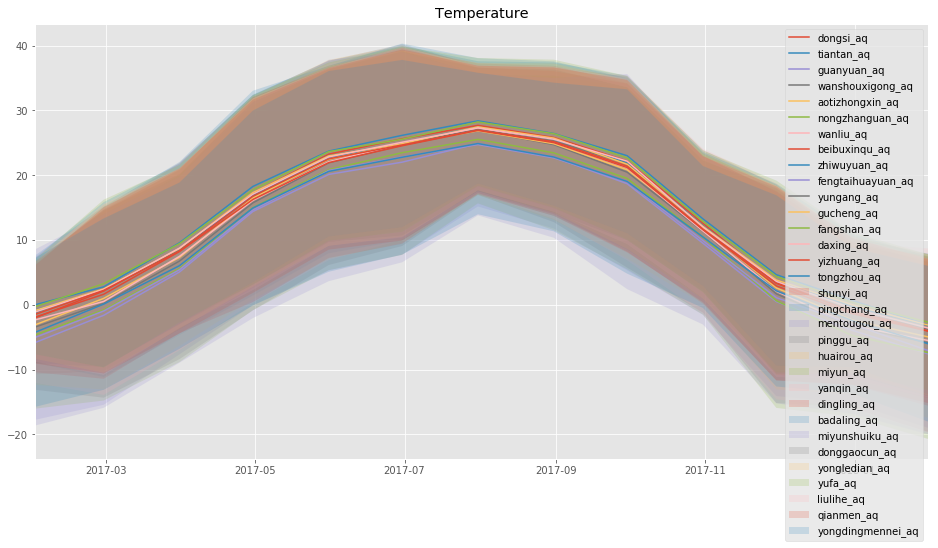

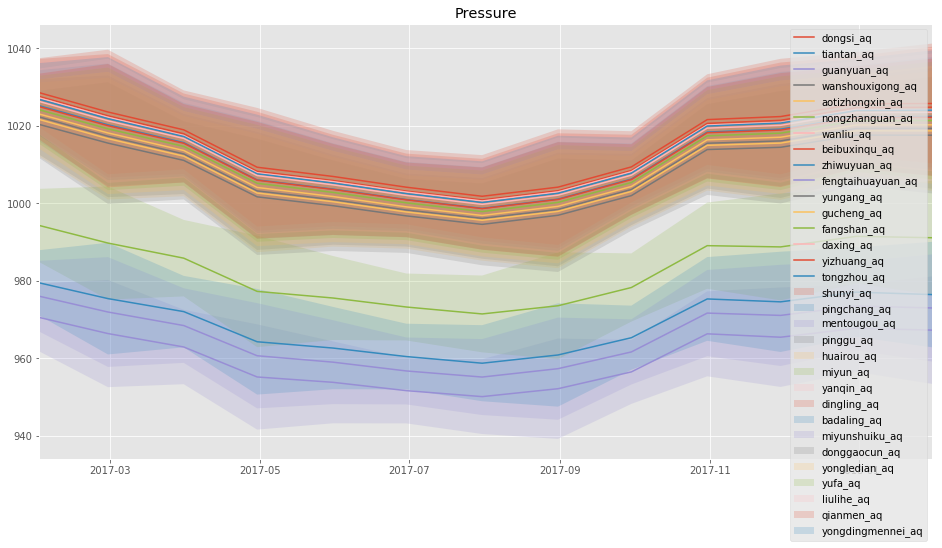

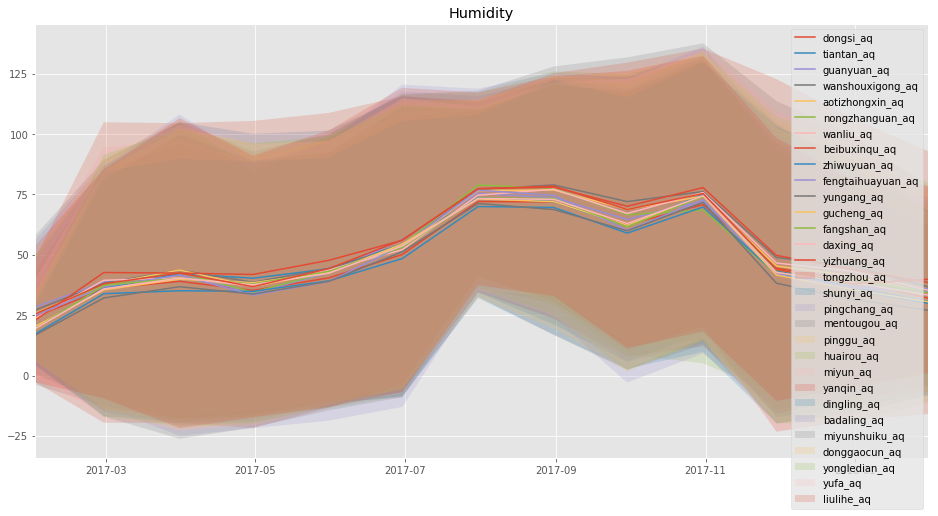

<Figure size 1152x576 with 0 Axes>

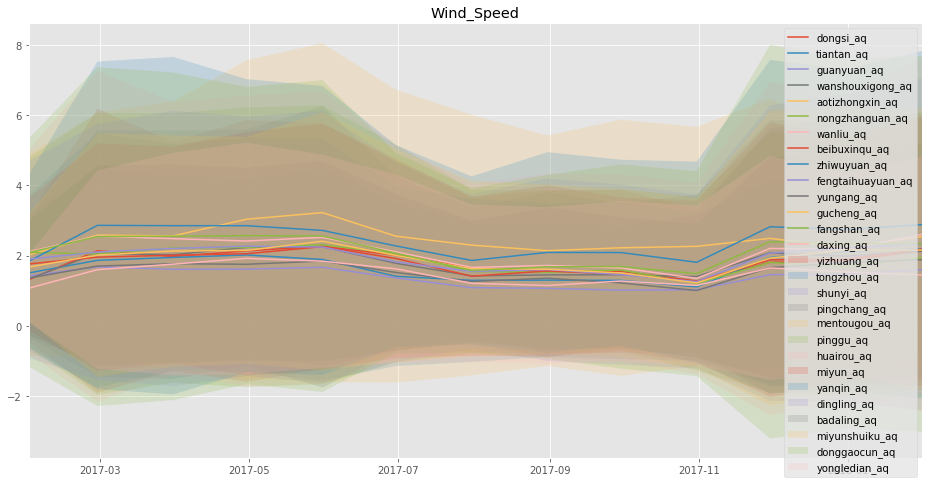

In [72]:
station_names = stations.index
w = weather.reset_index()
feature_names = w.columns.values[4:9]
for feature in feature_names:
    plt.figure(figsize=(16,8))
    for station in w.station.unique():
        resamples_mean = w[w['station'] == station].reset_index().set_index('datetime').resample('M').mean()[feature]
        resamples_std = w[w['station'] == station].reset_index().set_index('datetime').resample('M').std()[feature]
        if max(resamples_mean) > 1200:
            pass # There are some outliers
        else:    
            plt.plot(resamples_mean.index, resamples_mean, label = station)
            plt.fill_between(resamples_mean.index,
                         resamples_mean - 2.575 * resamples_std,
                         resamples_mean + 2.575 * resamples_std,
                 alpha=.2, label='99% confidence interval')
            y_perc = 99.
            plt.title(feature.title())
            plt.legend(station_names)
            plt.xlim([resamples_mean.index.min(),
                    resamples_mean.index.max()])

## Plot points as circle markers and show scale adding a colormap

In [73]:
from src.maps import map_points_circles

In [74]:
# Set the variables
feature = 'temperature'
date = w.datetime[1000]
print(date)

2017-03-13 08:00:00


In [68]:
map_points_circles(w, feature, date) # Select the date that you want

Temperature at time: 2017-03-13 08:00:00


In [70]:
map_points_circles(w, 'humidity', w.datetime[0])

Humidity at time: 2017-01-30 16:00:00
